In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections

pd.set_option("display.max_column", 999)

In [2]:
tourney_results = pd.concat([
    pd.read_csv("MNCAATourneyDetailedResults.csv"),
    pd.read_csv("WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv("MNCAATourneySeeds.csv"),
    pd.read_csv("WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv("MRegularSeasonDetailedResults.csv"),
    pd.read_csv("WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

In [3]:
tourney_results.shape

(2075, 34)

In [4]:
seeds.shape

(4098, 3)

In [5]:
regular_results.shape

(184024, 34)

In [6]:
regular_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [7]:
regular_results_swap = regular_results[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [8]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [9]:
regular_results_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,WScore,WLoc,NumOT,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20


In [10]:
regular_results_swap.loc[regular_results['WLoc'] == 'H', 'WLoc'] = 'A'
regular_results_swap.loc[regular_results['WLoc'] == 'A', 'WLoc'] = 'H'
regular_results.columns.values[6] = 'location'
regular_results_swap.columns.values[6] = 'location'

In [11]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,location,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


Swapping here so the model doesnt know

In [12]:
regular_results_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,WScore,location,NumOT,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25
3,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18
4,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20


In [13]:
regular_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(regular_results.columns)]
regular_results_swap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(regular_results.columns)]

In [14]:
regular_data = pd.concat([regular_results, regular_results_swap]).sort_index().reset_index(drop = True)

Replacing with T1 and T2 so their is no indication of who is winning 

In [15]:
regular_data.head(10)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
2,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
3,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
4,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
5,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25
6,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
7,2003,11,1457,50,1296,56,N,0,18,49,6,22,8,15,17,20,9,19,4,3,23,18,38,3,9,17,31,6,19,11,12,14,2,18
8,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14
9,2003,11,1208,71,1400,77,N,0,24,62,6,16,17,27,21,15,12,10,7,1,14,30,61,6,14,11,13,17,22,12,14,4,4,20


In [16]:
tourney_results = pd.concat([
    pd.read_csv("MNCAATourneyDetailedResults.csv"),
    pd.read_csv("WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv("MNCAATourneySeeds.csv"),
    pd.read_csv("WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv("MRegularSeasonDetailedResults.csv"),
    pd.read_csv("WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

In [17]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [18]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [19]:
regular_data.shape

(368048, 35)

In [20]:
tourney_data.shape

(4150, 35)

In [21]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

Getting Mean from season for below this 

In [22]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [23]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)
season_statistics.head()

T1_FGM     T1_FGA   T1_FGM3    T1_FGA3      T1_OR  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       19.142857  39.785714  7.821429  20.821429   4.178571   
       1103       27.148148  55.851852  5.444444  16.074074   9.777778   
       1104       24.035714  57.178571  6.357143  19.857143  13.571429   
       1105       24.384615  61.615385  7.576923  20.769231  13.500000   
       1106       23.428571  55.285714  6.107143  17.642857  12.285714   

                     T1_Ast      T1_TO    T1_Stl      T1_PF     T2_FGM  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       13.000000  11.428571  5.964286  18.750000  19.285714   
       1103       15.222222  12.629630  7.259259  19.851852  27.777778   
       1104       12.107143  13.285714  6.607143  18.035714  23.250000   
       1105       14.538462  18.653846  9.307692  20.230769  27.000000   
       1106       11.678571  17.035714  8.357143  18.178571  21.714286   

                     T2_FGA   T2_FGM3    T2_FGA3      T2_OR     T2_Ast  \
                       mean      mean       mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       42.428571  4.750000  12.428571   9.607143   9.142857   
       1103       57.000000  6.666667  18.370370  12.037037  15.481481   
       1104       55.500000  6.357143  19.142857  10.892857  11.678571   
       1105       58.961538  6.269231  17.538462  13.192308  15.807692   
       1106       53.392857  4.785714  15.214286  11.321429  11.785714   

                      T2_TO    T2_Stl    T2_Blk PointDiff  
                       mean      mean      mean      mean  
Season T1_TeamID                                           
2003   1102       12.964286  5.428571  1.571429  0.250000  
       1103       15.333333  6.407407  2.851852  0.629630  
       1104       13.857143  5.535714  3.178571  4.285714  
       1105       18.807692  9.384615  4.192308 -4.884615  
       1106       15.071429  8.785714  3.178571 -0.142857

In [24]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [25]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


## Breaking down into Team 1 and Team 2

In [26]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [27]:
season_statistics_T1.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [28]:
season_statistics_T2.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [29]:
mteams_df = pd.read_csv('MTeams.csv')
mteams_df

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2024
1,1102,Air Force,1985,2024
2,1103,Akron,1985,2024
3,1104,Alabama,1985,2024
4,1105,Alabama A&M,2000,2024
...,...,...,...,...
373,1474,Queens NC,2023,2024
374,1475,Southern Indiana,2023,2024
375,1476,Stonehill,2023,2024
376,1477,TX A&M Commerce,2023,2024


In [30]:
merged_df_T2 = pd.merge(season_statistics_T2, mteams_df, left_on='T2_TeamID', right_on='TeamID')

In [31]:
merged_df_T1 = pd.merge(season_statistics_T1, mteams_df, left_on='T1_TeamID', right_on='TeamID')
merged_df_T1.columns

Index(['Season', 'T1_TeamID', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean',
       'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean',
       'T1_PFmean', 'T1_opponent_FGMmean', 'T1_opponent_FGAmean',
       'T1_opponent_FGM3mean', 'T1_opponent_FGA3mean', 'T1_opponent_ORmean',
       'T1_opponent_Astmean', 'T1_opponent_TOmean', 'T1_opponent_Stlmean',
       'T1_opponent_Blkmean', 'T1_PointDiffmean', 'TeamID', 'TeamName',
       'FirstD1Season', 'LastD1Season'],
      dtype='object')

# Ken Pom Here

In [32]:
Pomeroy_data = 'kenpom_2023.csv'
pomeroy_df = pd.read_csv(Pomeroy_data)
pomeroy_df

# Display df
pomeroy_df

,Unnamed: 0,Season,TeamName,adj_o,adj_d,adj_tempo,luck,sos_adj_o,sos_adj_d
0,0,2011,Ohio St.,125.4,88.4,66.0,0.043,107.4,98.3
1,1,2011,Duke,118.8,87.2,70.1,0.006,106.0,97.4
2,2,2011,Kansas,119.8,88.3,69.6,0.071,106.1,98.7
3,3,2011,Texas,114.0,85.3,67.2,-0.055,105.6,97.8
4,4,2011,Purdue,116.1,87.2,67.1,-0.004,108.1,97.3
...,...,...,...,...,...,...,...,...,...
4218,358,2023,Florida A&M;,89.0,110.7,64.1,-0.013,103.0,105.2
4219,359,2023,IUPUI,93.1,117.9,66.9,-0.079,102.1,108.0
4220,360,2023,Green Bay,90.6,116.6,65.1,0.031,104.4,106.9
4221,361,2023,LIU,85.7,114.3,72.0,-0.027,101.2,108.6


In [33]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import pandas as pd

# Assuming pomeroy_df and merged_df_T1 are your dataframes

# First, define a function to perform fuzzy matching
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=1):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()

    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m

    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))

    df_1['matches'] = m2

    return df_1

# Apply fuzzy matching on the 'TeamName' column
merged_df_T1_matched = fuzzy_merge(merged_df_T1, pomeroy_df, 'TeamName', 'TeamName', threshold=80)

# Merge the dataframes based on 'TeamName' and 'Season'
merged_data = pd.merge(merged_df_T1_matched, pomeroy_df, on=['TeamName', 'Season'], how='left')


In [68]:
merged_data_filtered = merged_data[merged_data['Season'] >= 2011]

merged_data_filtered.shape

(4928, 33)

In [67]:
nan_counts = merged_data_filtered.isnull().sum()
nan_counts

Season                     0
T1_TeamID                  0
T1_FGMmean                 0
T1_FGAmean                 0
T1_FGM3mean                0
T1_FGA3mean                0
T1_ORmean                  0
T1_Astmean                 0
T1_TOmean                  0
T1_Stlmean                 0
T1_PFmean                  0
T1_opponent_FGMmean        0
T1_opponent_FGAmean        0
T1_opponent_FGM3mean       0
T1_opponent_FGA3mean       0
T1_opponent_ORmean         0
T1_opponent_Astmean        0
T1_opponent_TOmean         0
T1_opponent_Stlmean        0
T1_opponent_Blkmean        0
T1_PointDiffmean           0
TeamID                     0
TeamName                   0
FirstD1Season              0
LastD1Season               0
matches                    0
Unnamed: 0              2421
adj_o                   2421
adj_d                   2421
adj_tempo               2421
luck                    2421
sos_adj_o               2421
sos_adj_d               2421
dtype: int64

## I wonder if these Nans have to do with teams not being in the tournament

# About to Merge with Tourney Data

In [34]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


In [35]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data = tourney_data.drop(tourney_data.filter(regex='_x|_y').columns, axis=1)

tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000


In [36]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(19014, 5)

In [37]:
regular_season_effects.head()

,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1323,1237,44,1
3,2003,1242,1221,24,1
4,2003,1390,1462,1,1


## Add in KenPom and Stars Here

In [38]:
pomeroy_df['Season'] = pomeroy_df['Season'].astype(str)
pomeroy_df.dtypes

Unnamed: 0      int64
Season         object
TeamName       object
adj_o         float64
adj_d         float64
adj_tempo     float64
luck          float64
sos_adj_o     float64
sos_adj_d     float64
dtype: object

In [39]:
mteams_df

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2024
1,1102,Air Force,1985,2024
2,1103,Akron,1985,2024
3,1104,Alabama,1985,2024
4,1105,Alabama A&M,2000,2024
...,...,...,...,...
373,1474,Queens NC,2023,2024
374,1475,Southern Indiana,2023,2024
375,1476,Stonehill,2023,2024
376,1477,TX A&M Commerce,2023,2024


# Get the Seeds so we can put in model

In [40]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [41]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.tail()

,Season,Seed,TeamID,seed
4093,2023,Z12,3405,12
4094,2023,Z13,3387,13
4095,2023,Z14,3241,14
4096,2023,Z15,3436,15
4097,2023,Z16,3151,16


In [42]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [43]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

get a seed difference for model 

In [44]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

In [45]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    4150.000000
mean        0.000000
std        17.332972
min       -89.000000
25%       -11.000000
50%         0.000000
75%        11.000000
max        89.000000
dtype: float64

In [46]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_seed,T2_seed,Seed_diff
0,2003,134,1421,92,1411,84,24.379310,56.793103,6.482759,18.000000,12.275862,13.034483,16.206897,7.068966,19.103448,27.793103,60.965517,7.620690,20.758621,13.724138,15.862069,12.827586,8.827586,4.241379,-7.241379,24.733333,55.266667,5.933333,18.500000,13.166667,14.200000,15.233333,6.433333,18.300000,25.666667,60.400000,7.533333,23.166667,11.933333,13.766667,14.333333,8.000000,2.600000,1.966667,16,16,0
1,2003,136,1112,80,1436,51,30.321429,65.714286,7.035714,20.071429,15.178571,17.642857,14.785714,8.464286,17.750000,26.357143,64.678571,6.321429,19.964286,13.107143,15.464286,16.857143,5.964286,2.392857,14.964286,24.827586,55.862069,5.275862,15.482759,12.965517,14.206897,14.068966,6.862069,15.896552,22.758621,55.068966,7.068966,21.448276,9.586207,13.275862,13.000000,7.103448,3.655172,4.655172,1,16,-15
2,2003,136,1113,84,1272,71,27.206897,56.896552,4.000000,12.586207,13.689655,15.551724,14.000000,5.206897,19.413793,24.793103,55.655172,5.448276,15.896552,11.000000,14.068966,15.517241,6.000000,3.931034,6.793103,26.275862,60.000000,7.000000,20.068966,14.068966,16.620690,13.793103,7.379310,18.758621,23.275862,57.862069,5.896552,18.310345,12.344828,13.310345,15.068966,7.275862,3.172414,8.689655,10,7,3
3,2003,136,1141,79,1166,73,26.620690,52.689655,6.827586,17.931034,10.586207,15.620690,18.241379,7.103448,20.965517,26.344828,57.931034,4.965517,13.896552,12.241379,11.793103,16.068966,8.448276,2.482759,6.103448,28.696970,57.454545,7.969697,20.484848,10.878788,16.818182,13.363636,8.393939,17.272727,23.878788,55.333333,4.878788,14.303030,11.060606,12.363636,17.060606,6.333333,2.575758,14.909091,11,6,5
4,2003,136,1143,76,1301,74,27.344828,58.724138,6.413793,17.034483,11.241379,16.000000,14.172414,6.551724,17.103448,25.379310,58.793103,7.103448,21.448276,11.172414,16.034483,14.931034,5.931034,2.517241,4.724138,24.333333,53.333333,7.966667,22.500000,9.733333,14.666667,14.200000,7.766667,18.666667,23.433333,53.133333,5.733333,17.000000,10.533333,12.566667,14.633333,7.433333,2.833333,4.400000,8,9,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4145,2022,147,3301,87,3163,91,29.125000,62.687500,7.406250,20.093750,10.062500,14.250000,12.062500,7.281250,13.187500,21.562500,60.625000,5.937500,21.000000,8.500000,9.843750,13.812500,5.937500,3.531250,19.343750,29.400000,60.066667,7.000000,20.500000,8.933333,18.833333,13.566667,9.300000,13.566667,20.333333,57.733333,5.800000,20.433333,7.633333,10.800000,15.200000,5.833333,2.233333,20.600000,1,2,-1
4146,2022,147,3276,50,3257,62,26.571429,58.607143,4.785714,15.000000,11.107143,13.964286,15.392857,6.857143,16.142857,22.928571,58.500000,6.214286,19.535714,8.178571,11.571429,14.964286,8.285714,3.500000,11.178571,28.344828,61.965517,6.137931,16.793103,11.413793,15.862069,14.172414,9.586207,15.896552,19.551724,53.551724,4.896552,16.793103,8.275862,10.413793,18.206897,5.689655,2.931034,17.137931,3,1,2
4147,2022,151,3390,58,3163,63,27.709677,61.677419,7.225806,20.419355,11.580645,15.129032,12.419355,8.612903,15.967742,20.193548,57.516129,5.548387,16.935484,8.645161,9.387097,14.677419,6.838710,2.290323,16.903226,29.400000,60.066667,7.000000,20.500000,8.933333,18.833333,13.566667,9.300000,13.566667,20.333333,57.73333

## See all our features for Model

In [47]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    ["Seed_diff"]

features

['T1_FGMmean',
 'T1_FGAmean',
 'T1_FGM3mean',
 'T1_FGA3mean',
 'T1_ORmean',
 'T1_Astmean',
 'T1_TOmean',
 'T1_Stlmean',
 'T1_PFmean',
 'T1_opponent_FGMmean',
 'T1_opponent_FGAmean',
 'T1_opponent_FGM3mean',
 'T1_opponent_FGA3mean',
 'T1_opponent_ORmean',
 'T1_opponent_Astmean',
 'T1_opponent_TOmean',
 'T1_opponent_Stlmean',
 'T1_opponent_Blkmean',
 'T1_PointDiffmean',
 'T2_FGMmean',
 'T2_FGAmean',
 'T2_FGM3mean',
 'T2_FGA3mean',
 'T2_ORmean',
 'T2_Astmean',
 'T2_TOmean',
 'T2_Stlmean',
 'T2_PFmean',
 'T2_opponent_FGMmean',
 'T2_opponent_FGAmean',
 'T2_opponent_FGM3mean',
 'T2_opponent_FGA3mean',
 'T2_opponent_ORmean',
 'T2_opponent_Astmean',
 'T2_opponent_TOmean',
 'T2_opponent_Stlmean',
 'T2_opponent_Blkmean',
 'T2_PointDiffmean',
 'T1_seed',
 'T2_seed',
 'Seed_diff']

In [48]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [49]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [50]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [51]:
xgb_cv = []
repeat_cv = 10 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )


Fold repeater 0
[16:49:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:49:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:49:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:49:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:49:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-mae:13.27024+0.12169	test-mae:13.27661+0.48876
[50]	tr

[50]	train-mae:9.43849+0.04480	test-mae:9.72558+0.24864
[100]	train-mae:9.03850+0.04734	test-mae:9.56056+0.19715
[150]	train-mae:8.79252+0.05078	test-mae:9.52737+0.20515
[200]	train-mae:8.57956+0.05058	test-mae:9.51342+0.20265
[227]	train-mae:8.47768+0.05351	test-mae:9.51541+0.20713
Fold repeater 7
[16:50:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:50:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:50:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:50:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Para

In [52]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([179, 138, 164, 261, 229, 210, 202, 156, 131, 179],
 [9.535479130098619,
  9.542759651218551,
  9.525393313040217,
  9.506152320769896,
  9.52882391271821,
  9.493136334146362,
  9.511871101482805,
  9.512043947340494,
  9.562542131895043,
  9.50776916318629])

In [53]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
[16:50:58] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:51:00] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:51:01] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:51:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:51:04] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Fold repeater 1
[16:51:06] WARNING: /var/folders/nz/j6p8yfhx1mv_

[16:52:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

Fold repeater 9
[16:52:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:52:09] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:52:11] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:52:12] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:52:14] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000

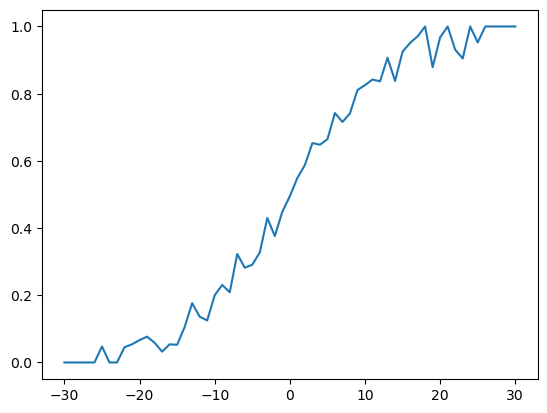

In [54]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [55]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5194392776690502
logloss of cvsplit 1: 0.5193405929820203
logloss of cvsplit 2: 0.5189278002575632
logloss of cvsplit 3: 0.5184994936707522
logloss of cvsplit 4: 0.519324861606671
logloss of cvsplit 5: 0.5189123237728177
logloss of cvsplit 6: 0.5191228431412295
logloss of cvsplit 7: 0.5182052895884451
logloss of cvsplit 8: 0.5186176646724554
logloss of cvsplit 9: 0.5178771692644425


In [56]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.518748938259545
adjusted logloss of cvsplit 1: 0.5179184495273718
adjusted logloss of cvsplit 2: 0.5181322360696738
adjusted logloss of cvsplit 3: 0.5179039228871833
adjusted logloss of cvsplit 4: 0.5182207901092544
adjusted logloss of cvsplit 5: 0.5180207071793098
adjusted logloss of cvsplit 6: 0.5180231762040537
adjusted logloss of cvsplit 7: 0.5170265804241665
adjusted logloss of cvsplit 8: 0.5177234887442348
adjusted logloss of cvsplit 9: 0.5166226540517633


In [57]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.1004515654330875
adjusted logloss of cvsplit 1: 1.0996110714644782
adjusted logloss of cvsplit 2: 1.1005969531646291
adjusted logloss of cvsplit 3: 1.0994118456647757
adjusted logloss of cvsplit 4: 1.099491689233393
adjusted logloss of cvsplit 5: 1.0998190216719066
adjusted logloss of cvsplit 6: 1.099602474903466
adjusted logloss of cvsplit 7: 1.0995338721691295
adjusted logloss of cvsplit 8: 1.0996670192116302
adjusted logloss of cvsplit 9: 1.0985194521215733


In [58]:
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)   

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_seed,T2_seed,Seed_diff
3089,2018,137,1438,54,1420,74,25.000000,54.181818,7.363636,18.878788,8.393939,13.727273,8.575758,6.787879,14.060606,18.818182,50.151515,6.151515,20.303030,8.393939,8.848485,12.727273,3.878788,2.636364,14.151515,25.612903,58.451613,9.838710,25.774194,9.709677,14.870968,11.677419,7.387097,16.516129,25.322581,56.612903,8.322581,23.161290,9.935484,13.580645,14.322581,6.258065,2.806452,1.516129,1,16,-15
3346,2023,137,1345,58,1192,63,25.441176,55.382353,6.882353,21.088235,11.029412,15.500000,10.411765,4.794118,13.705882,24.058824,57.705882,6.411765,20.411765,6.323529,12.382353,9.088235,6.000000,2.941176,10.352941,27.781250,61.593750,7.843750,22.781250,9.875000,14.312500,11.156250,7.437500,19.125000,26.656250,55.062500,8.156250,22.093750,7.687500,15.031250,14.187500,5.593750,3.875000,0.312500,1,16,-15
2680,2012,137,1181,70,1250,75,25.757576,56.272727,8.121212,21.606061,11.909091,12.454545,12.181818,6.242424,18.181818,25.515152,58.909091,4.454545,14.060606,11.696970,11.151515,12.909091,5.666667,2.666667,9.060606,25.750000,57.812500,7.406250,20.875000,10.843750,13.000000,11.531250,7.812500,17.781250,23.187500,55.562500,5.968750,17.906250,10.218750,13.062500,14.687500,5.687500,3.843750,10.218750,2,15,-13
2683,2012,137,1281,84,1313,86,28.000000,55.588235,8.235294,20.823529,9.176471,16.205882,10.294118,8.205882,14.117647,24.617647,55.794118,6.235294,17.205882,10.764706,12.823529,14.411765,5.264706,2.647059,14.558824,24.312500,54.281250,5.343750,17.031250,11.187500,12.000000,14.812500,6.531250,19.093750,23.375000,57.687500,5.625000,18.468750,12.281250,11.093750,13.656250,6.593750,3.125000,2.812500,2,15,-13
2743,2013,137,1207,68,1195,78,23.000000,50.419355,5.870968,16.419355,9.225806,14.806452,12.677419,7.548387,16.870968,19.419355,51.612903,5.354839,17.580645,10.806452,10.903226,14.225806,6.354839,3.290323,8.838710,26.218750,57.500000,6.625000,20.031250,11.687500,13.718750,14.656250,8.812500,17.593750,23.625000,57.468750,6.875000,21.843750,12.000000,13.281250,15.656250,6.937500,3.031250,5.031250,2,15,-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,2021,137,1317,78,1345,69,25.080000,53.280000,7.400000,19.840000,7.280000,13.040000,12.560000,6.840000,5.520000,21.320000,52.920000,5.720000,18.120000,7.720000,9.160000,13.520000,6.480000,2.960000,7.640000,25.518519,56.555556,7.111111,21.222222,9.666667,14.296296,11.888889,5.185185,4.481481,23.333333,56.333333,8.111111,25.740741,7.407407,14.074074,10.703704,5.592593,3.444444,4.814815,13,4,9
1146,2021,138,1325,62,1438,58,29.545455,60.681818,8.590909,23.500000,8.500000,17.636364,11.545455,6.636364,4.136364,25.954545,58.454545,7.863636,23.363636,8.000000,13.681818,14.136364,5.636364,2.409091,7.045455,25.333333,52.750000,8.500000,22.291667,5.541667,13.958333,8.583333,4.916667,3.375000,22.041667,53.000000,6.708333,19.708333,5.875000,11.625000,8.625000,5.125000,2.333333,8.166667,13,4,9
1256,2023,136,1202,68,1438,67,28.000000,58.774194,9.387097,27.290323,8.935484,16.387097,10.612903,6.354839,17.258065,25.838710,57.645161,6.709677,20.258065,8.258065,11.161290,11.870968,5.580645,2.580645,9.000000,24.031250,53.468750,6.812500,19.281250,6.937500,15.812500,8.125000,6.906250,14.312500,21.562500,51.906250

In [59]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.49379370115241167
adjusted logloss of cvsplit 1: 0.49324480242930685
adjusted logloss of cvsplit 2: 0.49368071832933585
adjusted logloss of cvsplit 3: 0.4927445574535619
adjusted logloss of cvsplit 4: 0.4932244147503151
adjusted logloss of cvsplit 5: 0.493151575242407
adjusted logloss of cvsplit 6: 0.49311687598179516
adjusted logloss of cvsplit 7: 0.49254783520997625
adjusted logloss of cvsplit 8: 0.4932393640706907
adjusted logloss of cvsplit 9: 0.4922153107145412


In [60]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.49379370115241167
adjusted logloss of cvsplit 1: 0.49324480242930685
adjusted logloss of cvsplit 2: 0.49368071832933585
adjusted logloss of cvsplit 3: 0.4927445574535619
adjusted logloss of cvsplit 4: 0.4932244147503151
adjusted logloss of cvsplit 5: 0.493151575242407
adjusted logloss of cvsplit 6: 0.49311687598179516
adjusted logloss of cvsplit 7: 0.49254783520997625
adjusted logloss of cvsplit 8: 0.4932393640706907
adjusted logloss of cvsplit 9: 0.4922153107145412


season
2003    0.522089
2004    0.483055
2005    0.485678
2006    0.552691
2007    0.421830
2008    0.455990
2009    0.462552
2010    0.469686
2011    0.481561
2012    0.488330
2013    0.507786
2014    0.492135
2015    0.424935
2016    0.537836
2017    0.477070
2018    0.530710
2019    0.428936
2021    0.530322
2022    0.537236
2023    0.575304
dtype: float64

# Do Submission formatting Below This 